# Crime rate in Denmark

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import requests
from bs4 import BeautifulSoup
import os
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
#from matplotlib.venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

The aim of this project is to visualise crime rates in Danish municipalities for the period 2008 to 2022. The data were obtained from Danmarks Statistik and used the series total population and total number of crime by municipality (criminality) which includes all offences under the Danish criminal code but not those under the Danish traffic law. 

In summary, for this project, both databases were loaded and cleaned, which consisted of removing those columns or rows that did not contain information. Given that both were quarterly series, they were annualised. In the case of total population, it was decided to use the information contained in the fourth quarter of each year, as it was a stock. For crime, the sum of the four quarters was added up, as the information reported was a flow. 

Subsequently, both databases were merged and the crime indicator per 100,000 inhabitants was estimated, which is defined as follows:


$$
index =  \frac{crim * 100.000}{pop}
$$

To facilitate the analysis, two graphs were constructed, the first is an interactive graph where the user can observe the evolution of criminality for each municipality, the second is a scatter graph that shows whether there is a correlation between population and criminality. 

# Read and clean data

The data is imported from an excel database

In [2]:
# Uploading our excel datasets (criminalitydata and population) and visualizing the first 5 rows
criminality = 'data/criminalitydata.xlsx'
criminality = pd.read_excel(criminality, skiprows=2)

pop = 'data/population.xlsx'
pop = pd.read_excel(pop, skiprows=2)

In [3]:
# Cleaning the data
# Deleting the column that has no information
data = [criminality, pop]
for i in data:
    i.drop("Unnamed: 0", axis = 1, inplace = True)

# Deleting the rows that has no informtion in the criminality dataset
criminality.drop(index = 101, inplace=True)
criminality.drop(index = 100, inplace=True)

In [4]:
# Renaming the "Unnamed: 1" to municipalities
for i in data:
    i.rename(columns = {"Unnamed: 1" : "municipalities"}, inplace=True)


# Renaming the rest of the columns in both databases so that they don't start with a number
for n,i in enumerate(data):
    for h in range(2007, 2022+1):
        for j in range(1, 4+1):
            if n == 0:  # This is the first dataset, i.e criminality data
                i.rename(columns={ str(str(h)+"Q"+str(j)):f'crim_{h}Q{j}'}, inplace = True)
            else:
                i.rename(columns={ str(str(h)+"Q"+str(j)):f'pop_{h}Q{j}'}, inplace = True)


# Creating the total per year
for h in range(2007, 2022+1):
    criminality[f'crim_{h}'] = criminality[f'crim_{h}Q1'] + criminality[f"crim_{h}Q2"] + criminality[f"crim_{h}Q3"] + criminality[f"crim_{h}Q4"]
    
for h in range(2008, 2022+1):
    pop[f'pop_{h}'] = pop[f"pop_{h}Q4"] # taking the last quarter of population per year as we want yearly data.
    


#extract only the variables which have the years values
criminality_year = criminality[['municipalities', 'crim_2007', 'crim_2008', 
                                'crim_2009', 'crim_2010', 'crim_2011', 'crim_2012', 
                                'crim_2013', 'crim_2014', 'crim_2015', 'crim_2016', 'crim_2017', 
                                'crim_2018', 'crim_2019', 'crim_2020', 'crim_2021', 'crim_2022']]

#extract only the value of the years
pop_year = pop[['municipalities', 'pop_2008', 'pop_2009', 'pop_2010', 'pop_2011', 
                'pop_2012', 'pop_2013', 'pop_2014', 'pop_2015', 'pop_2016', 
                'pop_2017', 'pop_2018', 'pop_2019', 'pop_2020', 'pop_2021', 'pop_2022']]



## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

/var/folders/0j/w3qt49pj7d19pfkd8ry8bfsh0000gn/T/ipykernel_27843/3819073626.py:15: UserWarning:

FixedFormatter should only be used together with FixedLocator



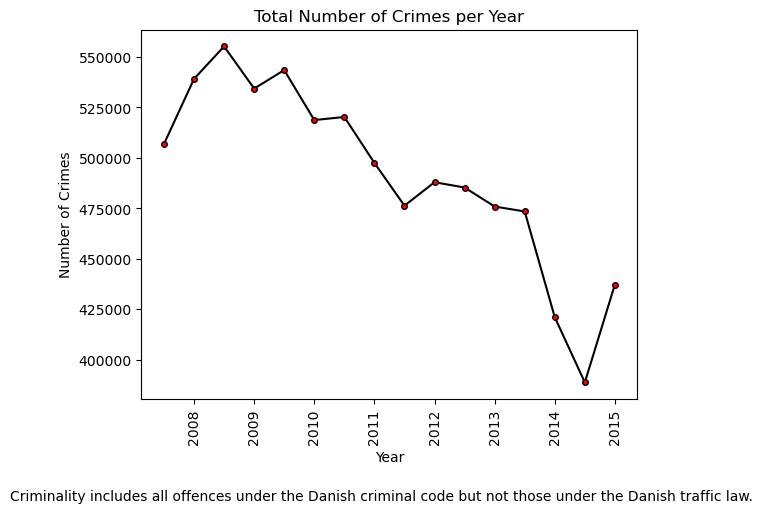

In [15]:
import matplotlib.pyplot as plt

# Define the years and the corresponding columns in the dataframe
years = range(2007, 2023)
cols = [f'crim_{year}' for year in years]

# Calculate the total number of crimes per year
crime_totals = criminality_year[cols].sum()

# Create the line graph with red points
fig, ax = plt.subplots()
ax.plot(years, crime_totals, '-o', color='black', markersize=4, markerfacecolor='red')

# Set the year labels to be vertical
ax.set_xticklabels(years, rotation=90)

# Add a title and axis labels
ax.set_title('Total Number of Crimes per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Crimes')

# Add a note about criminality
fig.text(0.5, -0.1, 'Criminality includes all offences under the Danish criminal code but not those under the Danish traffic law.', ha='center')

plt.show()

In [5]:
from ipywidgets import interact, widgets

# Define the interactive widget for selecting the year
year_widget = widgets.IntSlider(
    value=2007,
    min=2007,
    max=2022,
    step=1,
    description='Year:'
)

# Define the function that creates the proportional area chart
def create_chart(year):
    # Filter the data to only include the selected year and drop the row with the "Unknown municipality" value
    year_data = criminality_year[['municipalities', f'crim_{year}']].drop(criminality_year.index[criminality_year['municipalities'] == 'Unknown municipality'])
    
    # Calculate the total crimes for the year
    total_crimes = year_data[f'crim_{year}'].sum()
    
    # Calculate the proportional area for each municipality
    year_data['area'] = year_data[f'crim_{year}']/total_crimes
    
    # Sort the data by crime in descending order
    year_data = year_data.sort_values(by=f'crim_{year}', ascending=False)
    
    # Get the top 50 municipalities by crime
    top_municipalities = year_data.iloc[:50, :]
    
    # Calculate the cumulative proportion of crimes and the index of the row where the cumulative proportion exceeds 0.5
    top_municipalities['cumulative_prop'] = top_municipalities['area'].cumsum()
    index_cutoff = top_municipalities[top_municipalities['cumulative_prop'] > 0.5].index[0]
    
    # Aggregate the municipalities that represent less than 50% of the crimes into a single observation
    rest_of_municipalities = year_data.iloc[50:, :]
    rest_of_municipalities = pd.DataFrame(rest_of_municipalities.sum(numeric_only=True)).T
    rest_of_municipalities['municipalities'] = 'rest of municipalities'
    rest_of_municipalities['area'] = 1 - top_municipalities.iloc[:index_cutoff, :]['area'].sum()
    
    # Combine the top municipalities and the aggregated municipalities
    year_data = pd.concat([top_municipalities.iloc[:index_cutoff, :], rest_of_municipalities], ignore_index=True)
    
    # Create a label showing the percentage of crimes for each municipality
    year_data['label'] = year_data.apply(lambda row: f"{row['municipalities']}: {row['crim_' + str(year)] / total_crimes:.2%}", axis=1)
    
    # Create the chart using Plotly Express
    fig = px.treemap(year_data, path=['municipalities'], values='area', color='municipalities', hover_data=['label'])
    fig.update_layout(
        title=f'Criminality Proportional Area Chart ({year})',
        xaxis_title='Municipality',
        yaxis_title='Proportional Area',
    )
    fig.show()

# Create the interactive widget
interact(create_chart, year=year_widget)

interactive(children=(IntSlider(value=2007, description='Year:', max=2022, min=2007), Output()), _dom_classes=…

<function __main__.create_chart(year)>

In [7]:
from ipywidgets import interact, widgets

# Define the interactive widget for selecting the year
year_widget = widgets.IntSlider(
    value=2008,
    min=2008,
    max=2022,
    step=1,
    description='Year:'
)

# Define the function that creates the proportional area chart
def create_chart(year):
    # Filter the data to only include the selected year
    year_data = pop_year[['municipalities', f'pop_{year}']]
    
    # Calculate the total population for the year
    total_pop = year_data[f'pop_{year}'].sum()
    
    # Calculate the proportional area for each municipality
    year_data['area'] = year_data[f'pop_{year}']/total_pop
    
    # Create the chart using Plotly Express
    fig = px.scatter(year_data, x='municipalities', y=f'pop_{year}', size='area', color='municipalities', size_max=50)
    fig.update_layout(
        title=f'Population Proportional Area Chart ({year})',
        xaxis_title='Municipality',
        yaxis_title='Population',
    )
    fig.show()

# Create the interactive widget
interact(create_chart, year=year_widget)



interactive(children=(IntSlider(value=2008, description='Year:', max=2022, min=2008), Output()), _dom_classes=…

<function __main__.create_chart(year)>

In [11]:
from IPython.display import display

# Create a function to plot the boxplot and statistics
def plot_boxplot(year):
    # Filter the dataframe for the given year
    year_col = f'crim_{year}'
    data = criminality_year[['municipalities', year_col]]

    # Sort the municipalities by the number of crimes
    sorted_data = data.sort_values(by=year_col, ascending=False)

    # Get the top and bottom 5 municipalities
    top_5 = sorted_data.head(5)
    bottom_5 = sorted_data.tail(5)

    # Calculate the mean and standard deviation
    mean = data[year_col].mean()
    std = data[year_col].std()

    # Create the boxplot
    fig, (ax1, ax2) = plt.subplots(2, 1)
    sns.boxplot(x=data[year_col], ax=ax1)
    ax1.set_title(f'Crime Distribution {year}')
    ax1.set_xlabel('Number of Crimes')

    # Create the subplot for the statistics
    # Create a bar plot for the top 5 and bottom 5 municipalities
    sns.barplot(x=year_col, y='municipalities', data=pd.concat([top_5, bottom_5]), ax=ax2)

    # Add a line for the mean and standard deviation
    ax2.axvline(x=mean, color='r', linestyle='--')
    ax2.axvline(x=mean+std, color='gray', linestyle='--')
    ax2.axvline(x=mean-std, color='gray', linestyle='--')
    ax2.set_yticks(range(len(top_5)+len(bottom_5)))
    ax2.set_yticklabels(list(top_5['municipalities']) + list(bottom_5['municipalities']), fontsize=8)

    plt.show()

# Create the interactive plot
year_slider = widgets.IntSlider(min=2007, max=2022, step=1, value=2007)
widgets.interactive(plot_boxplot, year=year_slider)

interactive(children=(IntSlider(value=2007, description='year', max=2022, min=2007), Output()), _dom_classes=(…

**Interpretation**

From the mean of the crime by year since 2007 until 2022, it is possible to see that it has been decreasing. This value however does not take into account the total population, hence we are, so far, only able to conclude over the number of realizations of crime.

In [29]:
# Wide to long dataframe
criminality_year_long = pd.wide_to_long(criminality_year, stubnames='crim_', i='municipalities', j='year')

pop_year_long = pd.wide_to_long(pop_year, stubnames='pop_', i='municipalities', j='year')

In [30]:
# Resetting the index for criminality and population to default
# Important for next step
criminality_year_long = criminality_year_long.reset_index()
pop_year_long = pop_year_long.reset_index()
criminality_year_long

,municipalities,year,crim_
0,Copenhagen,2007,93077.0
1,Frederiksberg,2007,8149.0
2,Dragør,2007,671.0
3,Tårnby,2007,5446.0
4,Albertslund,2007,2903.0
...,...,...,...
1595,Rebild,2022,1002.0
1596,Thisted,2022,1903.0
1597,Vesthimmerlands,2022,1590.0
1598,Aalborg,2022,14093.0


In [32]:
#interactive plot:
def plot(pop_year_long,criminality_year_long, municipalities): 
    I = pop_year_long['municipalities'] == municipalities
    pop_I = pop_year_long['municipalities'] == municipalities
    crim_I = criminality_year_long['municipalities'] == municipalities
    pop_data = pop_year_long.loc[pop_I,:]
    crim_data = criminality_year_long.loc[crim_I,:]
    fig, ax1 = plt.subplots()
    ax1.plot(pop_data['year'], pop_data['pop_'], '-o', label='Population') # remember name of population is "pop_"
    ax1.set_ylabel('Population', color='blue')
    ax1.set_title(f'Population and criminality of {municipalities}')

    ax2 = ax1.twinx()

    ax2.plot(crim_data['year'], crim_data['crim_'], '-o', color='red', label='Criminality')
    ax2.set_ylabel('Criminality (number of realizations)', color='red')

widgets.interact(plot, 
    pop_year_long = widgets.fixed(pop_year_long),
    criminality_year_long = widgets.fixed(criminality_year_long),
    municipalities = widgets.Dropdown(description='municipalities', 
                                    options=pop_year_long.municipalities.unique(), 
                                    value='Copenhagen')
);

interactive(children=(Dropdown(description='municipalities', options=('Copenhagen', 'Frederiksberg', 'Dragør',…

**Interactive plot**: The plot is interactive: municipality can be chosen to see the development of the criminality and population.

**Interpretation**

The graph shows how the total population and total acts of criminality has change over time by municipality. The population evolution is shown from 2008 to 2022, while the criminality is shown from 2007 to 2022.

Focusing on *criminality* and choosing one municipality,for instance Aalborg, we see that the crime was at it's highest in 2011 with around 21000 reported crimes. Crime has then been decreasing to less than half during lockdown in 2021. However, after lockdown the crime increased again. This can be explained by the restriction of social activities such as nightlife and the restriction of total amount of people in certain areas.

It is possible to find a similar drop in crime during lockdown in every municipality, howeverer the previous trends differ. For example, in Frederiksbergtthe criminality was decreasing before lockdown, while in Tamby, it was increasing.

Now, in terms of *population*, it is possible to find municipaltities with a strong increase while others have faced a decrease. For example, these are the cases of Aalborg and Struer, respectively.

Finally, the graph gives a initial guess of how is the relationship bertween *criminality* and *population*. We were expecting to find a strong positive correlation between these variables in all municipalities, such as the case of Haderslev. However, it is very common to find a negative relationship, such as in Copenhagen, Helsingor, and Hvidovre. It gives a first suggestion of a reduction in the rate of crimes in Denmark.

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

In [60]:
total = pd.merge(pop_year_long, criminality_year_long, on=['municipalities','year'], how='left')

total.head(10)

,municipalities,year,pop_,crim_
0,Copenhagen,2008,516962,95101.0
1,Frederiksberg,2008,95005,7971.0
2,Dragør,2008,13452,688.0
3,Tårnby,2008,40234,5947.0
4,Albertslund,2008,27817,3339.0
5,Ballerup,2008,47329,4592.0
6,Brøndby,2008,33689,3621.0
7,Gentofte,2008,69646,5469.0
8,Gladsaxe,2008,63138,4942.0
9,Glostrup,2008,20911,2892.0


**Interpretation**

Here we are merging the two dataset. Since the criminality information is from 2007 while the population is from 2008, we use a left pethod using the popuation dataset (the smaller) as base. It means that we drop the information of criminality of 2007. In addition, a new observation was created in the population dataset because of the "unknown" municipality in crime.


# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

In [61]:
#creating a variable of criminality index
total['crime_rate_per_cap'] = total['crim_'] / total['pop_']
total['crime_rate_per_100K'] = total['crime_rate_per_cap'] * 100000 
### Last one might be redundant, as it describes the same thing as the above - just scaled (see 'total'). Best regards Philip


total.iloc[:,1:].mean()

total # overview of crime; including crime rate per capita and crime rate per 100K


,municipalities,year,pop_,crim_,crime_rate_per_cap,crime_rate_per_100K
0,Copenhagen,2008,516962,95101.0,0.183961,18396.129696
1,Frederiksberg,2008,95005,7971.0,0.083901,8390.084732
2,Dragør,2008,13452,688.0,0.051145,5114.481118
3,Tårnby,2008,40234,5947.0,0.147810,14781.030969
4,Albertslund,2008,27817,3339.0,0.120035,12003.451127
...,...,...,...,...,...,...
1480,Morsø,2022,20022,825.0,0.041205,4120.467486
1481,Rebild,2022,30908,1002.0,0.032419,3241.879125
1482,Thisted,2022,43365,1903.0,0.043883,4388.331604
1483,Vesthimmerlands,2022,36423,1590.0,0.043654,4365.373528


In [62]:
total

,municipalities,year,pop_,crim_,crime_rate_per_cap,crime_rate_per_100K
0,Copenhagen,2008,516962,95101.0,0.183961,18396.129696
1,Frederiksberg,2008,95005,7971.0,0.083901,8390.084732
2,Dragør,2008,13452,688.0,0.051145,5114.481118
3,Tårnby,2008,40234,5947.0,0.147810,14781.030969
4,Albertslund,2008,27817,3339.0,0.120035,12003.451127
...,...,...,...,...,...,...
1480,Morsø,2022,20022,825.0,0.041205,4120.467486
1481,Rebild,2022,30908,1002.0,0.032419,3241.879125
1482,Thisted,2022,43365,1903.0,0.043883,4388.331604
1483,Vesthimmerlands,2022,36423,1590.0,0.043654,4365.373528


**Interpretation**


Text(0, 0.5, 'Logs difference of crime rate per capita in Aalborg')

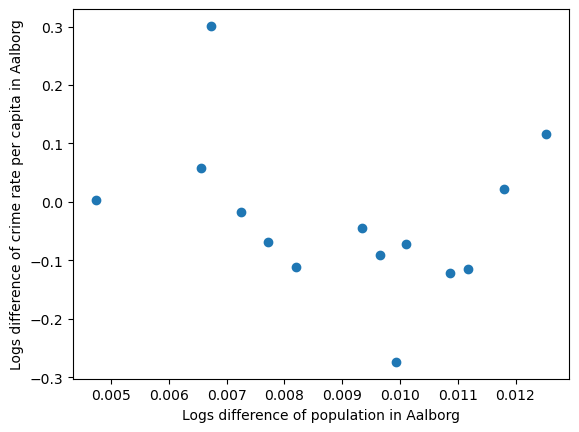

In [63]:
# Taking log of crime rate per capita and population for Aalborg
aalborg=total.loc[total["municipalities"] == "Aalborg"] # Assign all rows that contains Aalborg from our merged data "total".

# Taking logs of crime rate per capita in Aalborg
log_crpc_aalborg = np.log(aalborg.crime_rate_per_cap)
# Taking logs difference
log_diff_crpc_aalborg = log_crpc_aalborg.diff().dropna()

## Doing the same for population in Aalborg
log_pop_aalborg = np.log(aalborg.pop_)
log_diff_pop_aalborg = log_pop_aalborg.diff().dropna()


# Creating a scatter plot for Aalborg
plt.scatter(log_diff_pop_aalborg, log_diff_crpc_aalborg)
plt.xlabel("Logs difference of population in Aalborg")
plt.ylabel("Logs difference of crime rate per capita in Aalborg")

# Conclusion

ADD CONCISE CONLUSION.